# Time Series Modeling: Forecasting Real Estate Prices in Zillow

## Project Overview

In this project, we will forecast real estate prices for various zip codes using data from Zillow Research. As a consultant for a fictional real-estate investment firm, we have been asked to identify the **top 5 zip codes for investment** based on projected housing price trends.

This task requires us to:
- Preprocess the dataset.
- Conduct exploratory data analysis (EDA).
- Build time series forecasting models (ARIMA).
- Evaluate risk in terms of price volatility.
- Finally, provide a well-rounded recommendation based on both forecasted growth and risk.

Let's dive in!

### Step 1: Load the Data and Initial Filtering

In this step, we begin by loading the Zillow housing data. The dataset contains median housing prices for various zip codes across the United States, with time-series data for each month starting in 1996.

We will also filter the data for a subset of zip codes of interest. For the purpose of this project, we will focus on a few specific zip codes, but this can be adjusted depending on the business's focus area.

Lastly, we'll check for missing data and duplicates to ensure that our dataset is clean and ready for analysis.

In [6]:
import pandas as pd

# Load the Zillow data
df = pd.read_csv('Data/zillow_data.csv')

# Display first few rows to understand the structure
df.head()



,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [10]:
# Assuming date columns start from the 8th column and represent monthly data
# We'll calculate the percentage price change over the last 5 years (or a chosen time window)

# Calculate the percentage change in price over the last 60 months (5 years)
df['price_change'] = df.iloc[:, -60:].pct_change(axis=1).mean(axis=1)

# Sort by price growth and select the top 10 or top 20 zip codes based on price growth
top_growth_zip_codes = df.sort_values(by='price_change', ascending=False).head(10)['RegionName'].tolist()

# Filter the original dataframe to include only the top zip codes
df_filtered = df[df['RegionName'].isin(top_growth_zip_codes)]

# Display the filtered data
df_filtered.head()

# Check for missing data in the filtered dataset
df_filtered.isnull().sum()

RegionID        0
RegionName      0
City            0
State           0
Metro           0
               ..
2018-01         0
2018-02         0
2018-03         0
2018-04         0
price_change    0
Length: 273, dtype: int64

#### Significance of Step 1 Results

1. **Data Completeness**: 
   - The absence of missing values in both geographic identifiers (RegionID, RegionName, City, State, etc.) and monthly price data ensures that we have a reliable foundation for conducting time series forecasting. This means there will be no gaps in the data when we fit the ARIMA models, allowing for more accurate and consistent forecasts.
   
2. **Price Change Calculation Validity**:
   - The `price_change` column, which represents the average percentage price growth over the last 5 years, has been calculated for all selected zip codes without any missing values. This metric is crucial because it forms the basis for selecting the top-performing zip codes. Since the calculation is complete and valid, we can confidently proceed with analyzing and forecasting these zip codes to determine the best investment opportunities.

#### Importance in Overall Project

- **Robust Analysis Foundation**: With no missing data, the data preparation step ensures a robust foundation for time series modeling, reducing the risk of errors or inaccurate results later in the analysis.
- **Accurate Zip Code Selection**: The successful calculation of price changes ensures that the zip codes selected for further analysis are based on objective, data-driven growth trends. This selection is critical in identifying areas with strong growth potential, directly aligning with the project's goal of recommending the top 5 zip codes for real estate investment.


### Step 2: Data Preprocessing

We will ensure the time columns are correctly formatted as datetime objects, remove duplicates, and make the data ready for analysis.


In [20]:
# Helper function to convert only the date columns to datetime objects
def get_datetimes(df):
    # Filter the columns that represent dates (either starting with '19' or '20')
    date_cols = [col for col in df.columns if col.startswith('19') or col.startswith('20')]
    return pd.to_datetime(date_cols, format='%Y-%m')

# Extract dates and convert to datetime
dates = get_datetimes(df_filtered)

# Check for duplicates and drop them, ensuring no SettingWithCopyWarning by reassigning the result
df_filtered = df_filtered.drop_duplicates()

# Apply forward fill
df_filtered.fillna(method='ffill', inplace=True)

# Apply backward fill to handle NaNs that are at the start of the time series
df_filtered.fillna(method='bfill', inplace=True)

# Check if any NaN values remain
print(df_filtered.isnull().sum())





RegionID        0
RegionName      0
City            0
State           0
Metro           0
               ..
2018-01         0
2018-02         0
2018-03         0
2018-04         0
price_change    0
Length: 273, dtype: int64


### Step 3: Exploratory Data Analysis (EDA) and Visualization

We will visualize the price trends over time for each selected zip code to observe patterns, trends, and seasonality. This helps identify areas of strong growth and any potential outliers.


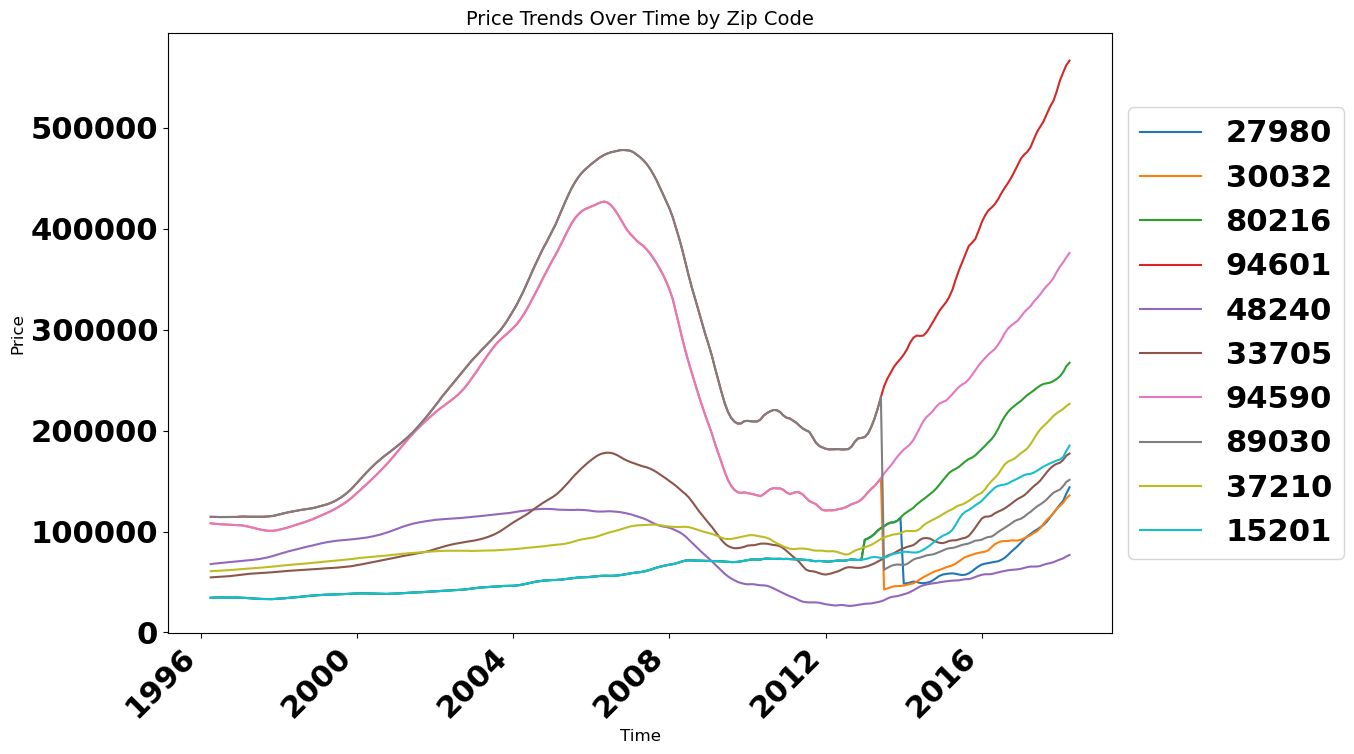

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

# Set to a widely supported font like DejaVu Sans (included with matplotlib)
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Suppress warnings related to fonts
warnings.filterwarnings("ignore", message="findfont: Font family 'normal' not found.")

# Plotting code
plt.figure(figsize=(14, 8))

for zip_code in top_growth_zip_codes:
    zip_data = df_filtered[df_filtered['RegionName'] == zip_code].iloc[:, 7:]  # Assuming data starts from column 7
    
    # Ensure matching dimensions by trimming extra columns in zip_data if necessary
    zip_data_trimmed = zip_data.iloc[:, :len(dates)].values.flatten()  # Trim to match the length of 'dates'
    
    plt.plot(dates, zip_data_trimmed, label=zip_code)

plt.legend(loc='center left', bbox_to_anchor=(1, .5))  # Place legend outside the plot
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Price Trends Over Time by Zip Code', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Automatically adjust layout to prevent overlap
plt.show()


#### Step 3 Results: Price Trends Over Time by Zip Code

This graph displays the housing price trends for various zip codes from 1996 to 2018. Each line represents a different zip code, showing how the median housing price has evolved over time. Key observations:

- **Sharp Increases**: Some zip codes (like `94601` and `94590`) experienced rapid price increases in recent years, suggesting these areas may be undergoing significant growth or gentrification.
- **Price Peaks and Recoveries**: Many zip codes saw a significant dip in prices around 2008, likely due to the housing crisis, followed by varying levels of recovery. For instance, `94601` shows strong post-2012 growth, while others are recovering more slowly.
- **Consistent Growth**: Some zip codes (e.g., `80216`, `33705`) show more steady, long-term growth without the extreme volatility seen in other areas.

This analysis can help identify potential investment opportunities based on historical trends, with zip codes showing strong post-recession recovery or consistent growth likely representing high-potential areas for real estate investment.
